# Steam Review Sentiment

A machine learning project to predict Steam game ratings (thumbs up/down) using review text and game metadata.

## Data Overview

- Our data is using 2970 rows to determine a Steam game rating.
    - Features:
        - Numeric Features (5):
            - VotesUp, VotesFunny, PlaytimeTotal, PlaytimeTwoWeeks, and NumberofReviews.
        - Text Features (1000):
            - The CountVectorizer is configured with max_features=1000, meaning it will create up to 1,000 features based on the most frequent words in the Review column.
        - Combined Features (1005):
            - The scipy.sparse.hstack function combines the 1,000 text features and the 5 numeric features into a single feature matrix
- The data was collected through a script we ran on our local machine to pull data from the `/review` endpoint from the Steam API.
- When collecting this data, we did not need to perform any initial transformations, just light transformation during feature engineering.

#### Details on the data
- What is your dependent variable? regression or classification? distribution?
    - **Dependent Variable**: The dependent variable is `Recommended`, which indicates whether a review is positive (thumbs up) or negative (thumbs down).
    - **Regression or Classification**: This is a `binary classification` problem since the target variable (Recommended) has two possible values: 1 (positive) or 0 (negative).
    - **Distribution**: You can check the distribution of the Recommended column to identify class imbalances.

### Data Descriptions

#### Continuous
- `VotesUp`: The number of users that found this review helpful
- `VotesFunny`: The number of users that found this review funny
- `PlaytimeTotal`: Lifetime playtime tracked in this app
- `PlaytimeReview`: Playtime when the review was written
- `PlaytimeTwoWeek`: Playtime tracked in the past two weeks for this app
- `NumberofReviews`: Number of reviews written by the user
- `PostedDate`: Date the review was created (unix timestamp)

#### Categorical
- `AppID`: The unique id of the game
- `GameName`: The name of the reviewed game
- `ReviewID`: The unique id of the recommendation
- `Author`: The user’s SteamID
- `Review`: Text of written review
- `Recommended`: True means it was a positive recommendation

## Import data

Import data using pandas. Data imported is in a CSV format.

In [53]:
import pandas as pd

# Load the dataset
file_path = "Dataset/steamreviews.csv"
steam_reviews = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(steam_reviews.head())

     AppID                  GameName   ReviewID             Author  \
0  3409570            Bricks Smasher  189034666  76561199483805980   
1  3409700  Honekawa Marionette Demo  186347944  76561198991875232   
2  3409750          Card Draw (Demo)  192050113  76561198973629547   
3  3409750          Card Draw (Demo)  191604297  76561198941797474   
4  3409750          Card Draw (Demo)  189258437  76561198261537547   

                                              Review  Recommended  VotesUp  \
0  Good, clean, silly fun! [i]Bricks Smasher[/i] ...         True        1   
1  I loved the art style and music. I love the lo...         True        1   
2  Very interesting game. Strategic mode is my fa...         True        1   
3  (I've been playing this on itch.io for a while...         True        1   
4  Very good game the best mode is strategy I sug...         True        1   

   VotesFunny  PlaytimeTotal  PlaytimeReview  PlaytimeTwoWeeks  \
0           0             56            48.0

## Training

### Perform some Feature Engineering

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import torch
import scipy

# Drop rows where Review or Recommended is missing
steam_reviews_clean = steam_reviews.dropna(subset=["Review", "Recommended"])

# Convert 'Recommended' column to binary labels
steam_reviews_clean["label"] = steam_reviews_clean["Recommended"].astype(int)

# -------- Numeric Features --------
numeric_cols = ["VotesUp", "VotesFunny", "PlaytimeTotal", "PlaytimeTwoWeeks", "NumberofReviews"]
X_numeric = steam_reviews_clean[numeric_cols].fillna(0)

# Scale numeric features
scaler = StandardScaler()
# Fit the scaler to the numeric data and transform it
X_numeric_scaled = scaler.fit_transform(X_numeric)

# -------- Text Features --------
# Convert text data into a matrix of token counts
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
# Fit and transform the text data
X_text = vectorizer.fit_transform(steam_reviews_clean["Review"])

# -------- Combine --------
# This will create a sparse matrix
X_combined = scipy.sparse.hstack([X_text, X_numeric_scaled])

# -------- Labels --------
# Note: StandardScaler expects 2D array, so we need to reshape if necessary
y = steam_reviews_clean["label"].values

# -------- Train/Test Split --------
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# -------- Convert to PyTorch Tensors --------
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


### Define Simple Neural Network

Details on neural network:
- One hidden layer
- ReLU activation
- Sigmoid output (since it's binary classification)

In [55]:
import torch.nn as nn

class SteamReviewClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SteamReviewClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize with the correct input size
input_dim = X_train_tensor.shape[1]
# Initialize the model
model = SteamReviewClassifier(input_dim)

### Train the Model

A simple training loop for several epochs

In [56]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Print training loss
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.6642
Epoch [2/10], Loss: 0.6448
Epoch [3/10], Loss: 0.6285
Epoch [4/10], Loss: 0.6145
Epoch [5/10], Loss: 0.6020
Epoch [6/10], Loss: 0.5907
Epoch [7/10], Loss: 0.5803
Epoch [8/10], Loss: 0.5707
Epoch [9/10], Loss: 0.5615
Epoch [10/10], Loss: 0.5528


### Evaluate the Model

In [57]:
from sklearn.metrics import accuracy_score, classification_report

# Switch to evaluation mode
model.eval()

# No need to compute gradients during evaluation
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
    y_pred = (y_pred_probs >= 0.5).float()

# Convert tensors to numpy for reporting
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Report metrics
print("Accuracy:", accuracy_score(y_test_np, y_pred_np))
print("\nClassification Report:\n", classification_report(y_test_np, y_pred_np))


Accuracy: 0.8451178451178452

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.01      0.02        93
         1.0       0.84      1.00      0.92       501

    accuracy                           0.85       594
   macro avg       0.92      0.51      0.47       594
weighted avg       0.87      0.85      0.78       594



### Save the Model

Save model to the onnx format to load it to a JavaScript app.

In [58]:
dummy_input = torch.randn(1, input_dim)
torch.onnx.export(
    model,
    dummy_input,
    "models/steam_review_model.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=11
)

## PCA

In [59]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=4)
pca.fit(X_combined.toarray())

# Explained Variance ratio
print("Variance Ratio:", pca.explained_variance_ratio_)

# Top components
print("Top Components:", pca.components_)

Variance Ratio: [0.17536444 0.09244535 0.06725868 0.03313976]
Top Components: [[ 0.0184764   0.01801459  0.00365953 ...  0.00492536  0.00218008
   0.04315835]
 [ 0.01185767  0.00667833  0.00234827 ...  0.01765226  0.01843195
   0.1650824 ]
 [-0.01963073 -0.0151595  -0.00340597 ... -0.03719291 -0.03764044
   0.12181863]
 [-0.01178848  0.00566924 -0.00124427 ...  0.69735966  0.69572452
  -0.02025729]]


The first principle component accounts for 17% of the varience and there is a large fall off after that. There are 1,005 features so the weights of the eigenvectors are naturally very small.

2969


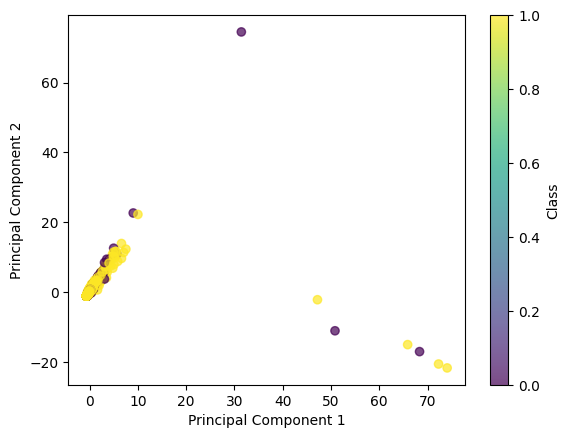

2969


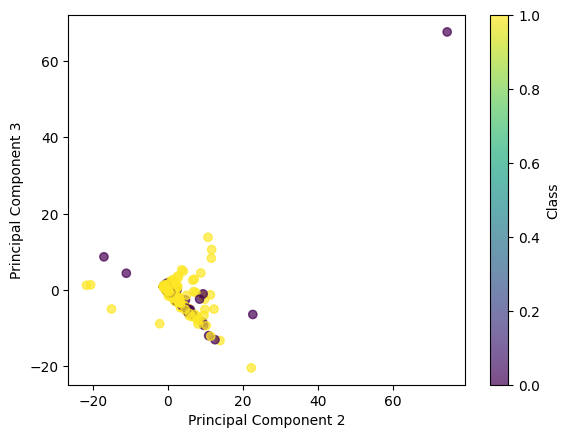

2969


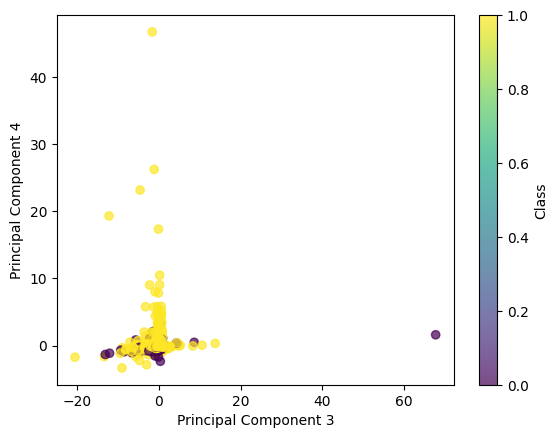

In [60]:
import matplotlib.pyplot as plt

# Project data onto the first two principal components
for i in range(3):
    X_pca = pca.transform(X_combined.toarray())
    print(len(X_pca))
    plt.scatter(X_pca[:, i], X_pca[:, i+1], c=y, cmap='viridis', alpha=0.7)
    plt.xlabel(f"Principal Component {i+1}")
    plt.ylabel(f"Principal Component {i+2}")
    plt.colorbar(label="Class")
    plt.show()

## K-means and data exploration

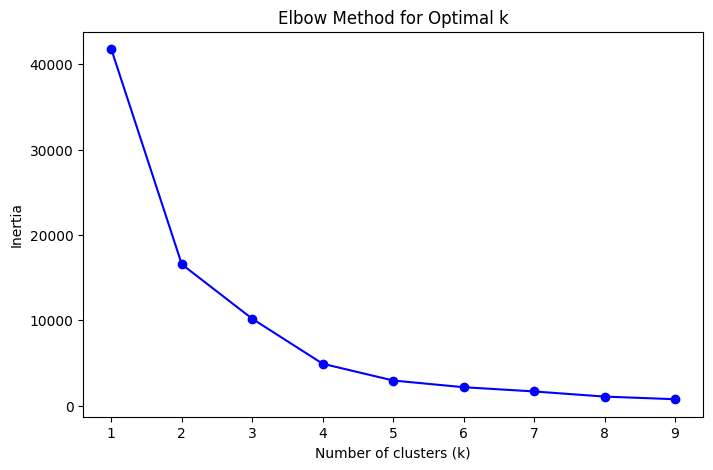

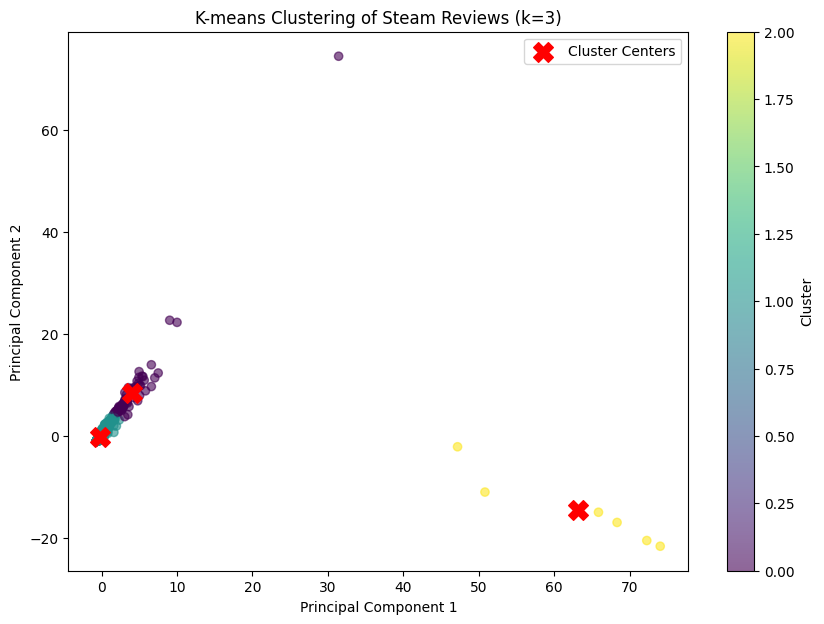

               PC1        PC2  Recommended
Cluster                                   
0         4.034524   8.495484     0.671429
1        -0.228468  -0.175359     0.850328
2        63.090318 -14.561762     0.666667

PCA Component Interpretation:
PC1 weights: [0.0184764  0.01801459 0.00365953 0.00330258 0.00992109]
PC2 weights: [0.01185767 0.00667833 0.00234827 0.00151639 0.00136548]

Cluster 0 Sample Reviews:
1. Atmosphere and art is there, but it should come with a better interface and a lot better English translation.  Because the game is a sequel to a free visual novel game, the beginning bombards you with...
2. TL;DR: Great demo so far! Really enjoying the graphics and gameplay so far. There will be feedback/updates to take into account to perfect it and make it better!   Updated: Was able to give pastries f...
3. [b]Note:[/b] An awesome friend gifted me a copy of this game. ^^  [h1]Like being at an art museum (sort of). XD[/h1]  [h2]Introduction[/h2]  [i]Cats of Mona Lisa - A hidd

In [61]:
from sklearn.cluster import KMeans
import numpy as np

# Reduce dimensionality for visualization and clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined.toarray())

# Calculate inertia for different k values
inertias = []
k_values = range(1, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


# Perform K-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Get cluster centers in PCA space
centers = kmeans.cluster_centers_

# Scatter plot of clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering of Steam Reviews (k=3)')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.show()


# Create a DataFrame for analysis
cluster_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': clusters,
    'Recommended': y
})

# Calculate mean values per cluster
cluster_stats = cluster_df.groupby('Cluster').mean()
print(cluster_stats)

# Examine the PCA components to interpret what they represent
print("\nPCA Component Interpretation:")
print("PC1 weights:", pca.components_[0][:5])  # First 5 features of PC1
print("PC2 weights:", pca.components_[1][:5])  # First 5 features of PC2


# Add cluster labels to our original dataframe
steam_reviews_clean['Cluster'] = clusters

# Print sample reviews from each cluster
for cluster in range(3):
    print(f"\nCluster {cluster} Sample Reviews:")
    cluster_reviews = steam_reviews_clean[steam_reviews_clean['Cluster'] == cluster]
    sample_reviews = cluster_reviews.sample(3, random_state=42)['Review']
    for i, review in enumerate(sample_reviews):
        print(f"{i+1}. {review[:200]}...")  # Print first 200 chars
    print(f"Recommendation Rate: {cluster_reviews['Recommended'].mean():.2f}")